# **📄 Document type classification **

## Contents
- Prepare Environments
- Import Library & Define Functions
- Hyper-parameters
- Load Data
- Train Model
- Inference & Save File


## 1. Prepare Environments

* 필요한 라이브러리를 설치합니다.

In [1]:
# 필요한 라이브러리 설치
# !pip install timm
# !pip install wandb
# !pip install matplotlib

## 2. Import Library & Define Functions
* 학습 및 추론에 필요한 라이브러리를 로드합니다.
* 학습 및 추론에 필요한 함수와 클래스를 정의합니다.

In [2]:
import os
import time
import random
import copy

import timm
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from albumentations.pytorch import ToTensorV2
import albumentations as A
from albumentations import ImageOnlyTransform
from augraphy import *
from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset

from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score

import matplotlib.pyplot as plt

In [3]:
# # 잘못된 label 업데이트
# train_df = pd.read_csv("data/train.csv")
# train_df.loc[428, 'target'] = 7
# train_df.loc[1095, 'target'] = 14
# train_df.loc[862, 'target'] = 3
# train_df.loc[192, 'target'] = 7
# train_df.loc[1237, 'target'] = 14
# train_df.loc[38, 'target'] = 10
# train_df.loc[340, 'target'] = 10

# train_df.to_csv("data/train.csv", index=False)

In [4]:
# 시드를 고정합니다.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

In [6]:
# 데이터셋 클래스를 정의합니다.
class ImageDataset(Dataset):
    def __init__(self, csv, path, transform=None, oversample=False):
        self.df = pd.read_csv(csv)
        self.path = path
        self.transform = transform
        self.oversample = oversample

        # 클래스간 불균형 해소를 위한 샘플 증식
        if self.oversample:
            # 각 클래스별로 데이터 수 계산
            class_counts = np.bincount(self.df.values[:, 1].astype(int))

            # 각 클래스별로 증식할 횟수 설정 (이 예제에서는 최대 데이터 수에 맞춤)
            max_class_count = max(class_counts)
            oversample_factors = [max_class_count // count for count in class_counts]
            # Class 3, 7 가중치 2로 변경
            oversample_factors[3] = 2
            oversample_factors[7] = 2 
            # oversample_factors[14] = 3 

            # 각 클래스별로 데이터를 증식한 새로운 데이터 프레임 생성
            oversampled_data = [self.df.values[self.df.values[:, 1] == cls].repeat(factor, axis=0) for cls, factor in enumerate(oversample_factors)]
            oversampled_data = np.vstack(oversampled_data)

            self.df = pd.DataFrame(oversampled_data, columns=self.df.columns)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        name, target = self.df.iloc[idx]
        img = np.array(Image.open(os.path.join(self.path, name)).convert("RGB"))
        
        if self.transform:
            img = self.transform(image=img)['image']
        return img, target
    
# meta.csv 파일 읽기
meta_data = pd.read_csv('/kkh/data/meta.csv')
label_to_class_name = dict(zip(meta_data['target'], meta_data['class_name']))
label_to_class_name = label_to_class_name.replace('df_', '')

In [7]:
# one epoch 학습을 위한 함수
def training(model, dataloader, criterion, optimizer, device, epoch, num_epochs):
    model.train()
    train_loss = 0
    preds_list = []
    targets_list = []

    pbar = tqdm(dataloader)
    for images, labels in pbar:
        images = images.to(device)
        labels = labels.to(device)

        model.zero_grad(set_to_none=True)

        preds = model(images)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
        targets_list.extend(labels.detach().cpu().numpy())

        pbar.set_description(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {loss.item()}")
        
    train_loss /= len(dataloader)
    train_acc = accuracy_score(targets_list, preds_list)    
    train_f1 = f1_score(targets_list, preds_list, average='macro')

    return model, train_loss, train_acc, train_f1

def evaluation(model, dataloader, criterion, device, epoch, num_epochs):
    model.eval()  # 모델을 평가 모드로 설정
    valid_loss = 0.0
    preds_list = []
    targets_list = []

    with torch.no_grad(): # model의 업데이트 막기
        tbar = tqdm(dataloader)
        for images, labels in tbar:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)
            loss = criterion(preds, labels)

            valid_loss += loss.item()
            preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
            targets_list.extend(labels.detach().cpu().numpy())

            tbar.set_description(f"Epoch [{epoch+1}/{num_epochs}] - Valid Loss: {loss.item()}")

    valid_loss = valid_loss / len(dataloader)
    valid_acc = accuracy_score(targets_list, preds_list)  
    valid_f1 = f1_score(targets_list, preds_list, average='macro')

    return valid_loss, valid_acc, valid_f1

def training_loop(model, train_dataloader, valid_dataloader, criterion, optimizer, device, num_epochs, patience, model_name):
    best_valid_loss = float('inf')  # 가장 좋은 validation loss를 저장
    early_stop_counter = 0  # 카운터
    valid_max_accuracy = -1
    best_model = None

    for epoch in range(num_epochs):
        model, train_loss, train_acc, train_f1 = training(model, train_dataloader, criterion, optimizer, device, epoch, num_epochs)
        valid_loss, valid_acc, valid_f1 = evaluation(model, valid_dataloader, criterion, device, epoch, num_epochs)

        monitoring_value = {'train_loss': train_loss, 'train_accuracy': train_acc, 'train_f1': train_f1, 
                            'valid_loss': valid_loss, 'valid_accuracy': valid_acc, 'valid_f1': valid_f1}
        
        print(f'''Epoch [{epoch + 1}/{num_epochs}] Finished
        Train Loss: {train_loss}, Train Accuracy: {train_acc}, Train F1: {train_f1}
        Valid Loss: {valid_loss}, Valid Accuracy: {valid_acc}, Valid F1: {valid_f1}''')

        if valid_acc > valid_max_accuracy:
          valid_max_accuracy = valid_acc

        # validation loss가 감소하면 모델 저장 및 카운터 리셋
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_model = model
            torch.save(model.state_dict(), f"./model_{model_name}.pt")
            early_stop_counter = 0
            print('Model Saved')

        # validation loss가 증가하거나 같으면 카운터 증가
        else:
            early_stop_counter += 1

        # 조기 종료 카운터가 설정한 patience를 초과하면 학습 종료
        if early_stop_counter >= patience:
            print("Early stopping")
            break

    return best_model, valid_max_accuracy

In [8]:
# 이미지 plotting을 위한 함수
def normalize_image(image):
    # 이미지를 [0, 1] 범위로 정규화
    image_min = image.min()
    image_max = image.max()
    normalized_image = (image - image_min) / (image_max - image_min)
    return normalized_image

def plot_images(images, labels, classes, normalize = True):

    n_images = len(images)
    
    num_rows = n_images // 3  # 행의 개수 계산
    if n_images % 3 != 0:
        num_rows += 1    
    fig, axes = plt.subplots(num_rows, 3, figsize=(30, 10 * num_rows))

    for i in range(n_images):
        image = images[i]
        label = classes[labels[i]]
        row_idx = i // 3
        col_idx = i % 3
        
        if normalize:
            image = normalize_image(image)
        
        axes[row_idx, col_idx].imshow(image.permute(1, 2, 0))
        axes[row_idx, col_idx].set_title(label)
        axes[row_idx, col_idx].axis('off')

    plt.show()

## 3. Hyper-parameters
* 학습 및 추론에 필요한 하이퍼파라미터들을 정의합니다.

In [9]:
# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# data config
data_path = '/kkh/data/'

# validation config
VALID_RATIO = 0.8

# model config
model_name = 'efficientnet_b4'
pretrained_size = 380
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds= [0.229, 0.224, 0.225]

# training config
LR = 5e-4
BATCH_SIZE = 32
dropout_ratio = 0.2
patience = 5
num_workers = 0
num_classes = 17

## 4. Load Data
* 학습, 검증, 테스트 데이터셋과 로더를 정의합니다.

In [10]:
# train image 변환을 위한 transform 코드
train_transform = A.Compose([
    # PatternGeneratorTransform(pattern, p=0.3), # 패턴 노이즈
    # A.Resize(height=pretrained_size, width=pretrained_size), # 이미지 크기 조정
    # 이미지 긴 측면 크기 조절 후 패딩 적용
    A.LongestMaxSize(max_size=pretrained_size, always_apply=True), 
    A.PadIfNeeded(min_height=pretrained_size, min_width=pretrained_size, border_mode=0, value=(255, 255, 255)),
    
    A.Normalize(mean=pretrained_means, std=pretrained_stds), # images normalization
    ToTensorV2() # numpy 이미지나 PIL 이미지를 PyTorch 텐서로 변환
])

# test image 변환을 위한 transform 코드
test_transform = A.Compose([    
    # A.Resize(height=pretrained_size, width=pretrained_size),
    A.LongestMaxSize(max_size=pretrained_size, always_apply=True),
    A.PadIfNeeded(min_height=pretrained_size, min_width=pretrained_size, border_mode=0, value=(255, 255, 255)),
    
    A.Normalize(mean=pretrained_means, std=pretrained_stds),
    ToTensorV2()
])

aug_test_transform = A.Compose([    
    A.RandomRotate90(),
    A.Flip(p=0.5),              
                        
    # A.Resize(height=pretrained_size, width=pretrained_size),
    A.LongestMaxSize(max_size=pretrained_size, always_apply=True),
    A.PadIfNeeded(min_height=pretrained_size, min_width=pretrained_size, border_mode=0, value=(255, 255, 255)),
    
    A.Normalize(mean=pretrained_means, std=pretrained_stds),
    ToTensorV2()
])

# 시각화를 위한 transform 코드
base_transform = A.Compose([
    ToTensorV2()
])

In [11]:
# Training Dataset 정의
train_dataset = ImageDataset(
    data_path + 'aug_train.csv',
    data_path + 'train/',
    transform=train_transform,
    oversample=True
)

# Test Dataset 정의
test_dataset = ImageDataset(
    data_path + 'sample_submission.csv',
    data_path + 'test/',
    transform=test_transform
)

aug_test_dataset = ImageDataset(
    data_path + 'sample_submission.csv',
    data_path + 'test/',
    transform=aug_test_transform
)

# 시각화용 Dataset 정의
train_dataset_v = ImageDataset(
    data_path + 'aug_train.csv',
    data_path + 'train/',
    transform=base_transform
)

test_dataset_v = ImageDataset(
    data_path + 'sample_submission.csv',
    data_path + 'test/',
    transform=base_transform
)

print(len(train_dataset), len(test_dataset))

14936 3140


In [12]:
# 데이터 셋을 학습 데이터 셋과 검증 데이터 셋으로 분리
total_size = len(train_dataset)
train_num, valid_num = int(total_size * VALID_RATIO), total_size - int(total_size * VALID_RATIO)

# train - valid set 나누기
generator = torch.Generator().manual_seed(SEED)
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [train_num, valid_num], generator = generator)

valid_data = copy.deepcopy(valid_dataset)
valid_data.dataset.transform = test_transform

print(f'Train dataset 개수: {len(train_dataset)}')
print(f'Validation dataset 개수: {len(valid_dataset)}')
print(f'Test dataset 개수: {len(test_dataset)}')

Train dataset 개수: 11948
Validation dataset 개수: 2988
Test dataset 개수: 3140


In [13]:
# DataLoader 정의
train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    drop_last=False
    )

valid_dataloader = DataLoader(
    valid_dataset, 
    batch_size = BATCH_SIZE, 
    shuffle = False,
    num_workers=0,
    pin_memory=True
    )

test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
    )

aug_test_dataloader = DataLoader(
    aug_test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
    )

In [14]:
# 변환된 학습 이미지 확인
N_IMAGES = 24

# 무작위로 선택된 인덱스 리스트를 생성
selected_indices = random.sample(range(len(train_dataset_v)), N_IMAGES)

images, labels = zip(*[(image, label) for image, label in [train_dataset_v[i] for i in selected_indices]])
# images, labels = zip(*[(image, label) for image, label in [train_dataset_v[i] for i in range(N_IMAGES)]])

plot_images(images, labels, label_to_class_name)

FileNotFoundError: [Errno 2] No such file or directory: '/kkh/data/train/df_cb59f25e8cd30a04.jpg'

## 5. Train Model
* 모델을 로드하고, 학습을 진행합니다.

In [ ]:
class AttentionModule(nn.Module):
    def __init__(self, in_features, out_features):
        super(AttentionModule, self).__init__()
        self.attention = nn.Sequential(
            nn.Linear(in_features, out_features),
            nn.Sigmoid()
        )

    def forward(self, x):
        attention_weights = self.attention(x)
        return x * attention_weights

class CustomEfficientNetB4(nn.Module):
    def __init__(self, num_classes, attention_size=1792):
        super(CustomEfficientNetB4, self).__init__()
        self.base_model = timm.create_model('efficientnet_b4', pretrained=True)
        
        # Remove the existing classifier
        self.base_model.reset_classifier(0, '')

        # Add attention mechanism
        self.attention = AttentionModule(attention_size, attention_size)

        # New classifier with attention
        self.classifier = nn.Linear(attention_size, num_classes)
        
    def forward(self, x):
        x = self.base_model(x)
        
        # Global average pooling
        x = x.mean([2, 3])

        # Apply attention mechanism
        x = self.attention(x)

        # Final classification
        x = self.classifier(x)

        return x

In [ ]:
# 모델 생성
model = CustomEfficientNetB4(num_classes).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR)

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/efficientnet_b4.ra2_in1k)
INFO:timm.models._hub:[timm/efficientnet_b4.ra2_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


In [ ]:
model

CustomEfficientNetB4(
  (base_model): EfficientNet(
    (conv_stem): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
          (bn1): BatchNormAct2d(
            48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
         

In [ ]:
# # Access model weights
# model_weights = model.state_dict()

# # Print or visualize the weights
# for param_tensor in model_weights:
#     print(param_tensor, "\t", model_weights[param_tensor].size())

In [ ]:
# # step 1: overfit the training set - overfit a single data point
# img, label = train_dataset[0]
# img = img.unsqueeze(0).to(device)
# label = torch.tensor([label]).to(device)

# for i in range(1000):
#   outputs = model(img) 
#   loss = loss_fn(outputs, label)
#   loss.backward()
#   optimizer.step() # should reach 1.0 accuracy and 0 loss
  
# # Evaluate the model after overfitting
# outputs = model(img)
# loss = loss_fn(outputs, label)
# acc = accuracy_score(label.detach().cpu().numpy(), outputs.argmax(dim=1).detach().cpu().numpy())
# print(f'Loss: {loss.item()}, Accuracy: {acc}')

In [ ]:
# run = wandb.init(project = 'soyoung', name = 'training')

# wandb에 모델의 weight & bias, graident 시각화
# run.watch(model, loss_fn, log = 'all', log_graph = True)


EPOCHS = 3

# model, valid_max_accuracy = training_loop(model, train_dataloader, valid_dataloader, loss_fn, optimizer, device, EPOCHS, patience, model_name, run)
model, valid_max_accuracy = training_loop(model, train_dataloader, valid_dataloader, loss_fn, optimizer, device, EPOCHS, patience, model_name)
print(f'Valid Max Accuracy: {valid_max_accuracy}')

Epoch [1/40] - Train Loss: 0.21207761764526367:  52%|█████▏    | 194/374 [1:20:01<1:13:59, 24.67s/it] 

In [ ]:
# run.unwatch()
# run.finish()

In [ ]:
torch.cuda.empty_cache()

# 6. Inference & Save File
* 테스트 이미지에 대한 추론을 진행하고, 결과 파일을 저장합니다.

In [ ]:
# model.load_state_dict(torch.load(f'./model_{model_name}.pt'))
# model.to(device)

# preds_list = []

# model.eval()
# for images, _ in tqdm(test_dataloader):
#     images = images.to(device)

#     with torch.no_grad():
#         preds = model(images)
#     preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())

100%|██████████| 99/99 [00:17<00:00,  5.75it/s]


- Test-Time Augmentation Ensemble
    - 학습 이미지에 RandomRotate90, Flip을 랜덤 적용하여 예측
    - 각 예측 결과 digits의 평균을 구해 앙상블 

In [ ]:
model.load_state_dict(torch.load(f'./model_{model_name}.pt'))
model.to(device)

N_TTA = 20
preds_list = []
with torch.no_grad():
    loaders = [test_dataloader] + [aug_test_dataloader] * N_TTA

    for batches in tqdm(zip(*loaders), total=len(test_dataloader)):
        images, *aug_images = [images.to(device) for images, _ in batches]

        outputs_original = model(images)
        outputs_augmented = [model(aug_image) for aug_image in aug_images]

        final_outputs = (outputs_original + sum(outputs_augmented)) / N_TTA + 1
        preds_list.extend(final_outputs.argmax(dim=1).cpu().numpy())

# 예측 결과 확인
print("Ensemble Predictions:", preds_list)

100%|██████████| 99/99 [06:24<00:00,  3.88s/it]

Ensemble Predictions: [2, 12, 5, 12, 2, 15, 0, 8, 15, 11, 5, 3, 16, 9, 15, 4, 14, 5, 13, 6, 12, 12, 1, 6, 3, 0, 14, 16, 12, 6, 3, 0, 13, 2, 5, 16, 13, 14, 3, 0, 5, 9, 12, 9, 0, 8, 5, 0, 11, 7, 10, 10, 10, 6, 7, 12, 9, 5, 13, 13, 12, 4, 5, 5, 6, 1, 5, 3, 10, 6, 3, 10, 8, 15, 7, 15, 6, 12, 12, 13, 8, 9, 9, 7, 10, 10, 5, 13, 10, 0, 10, 8, 5, 15, 3, 16, 11, 11, 14, 11, 14, 7, 13, 1, 15, 11, 2, 12, 16, 8, 6, 2, 0, 4, 12, 16, 2, 7, 11, 4, 2, 6, 5, 8, 10, 6, 4, 4, 3, 6, 5, 4, 15, 10, 16, 16, 3, 6, 6, 8, 4, 8, 14, 2, 12, 8, 3, 5, 9, 8, 6, 8, 16, 12, 11, 16, 9, 15, 6, 8, 5, 5, 10, 10, 16, 15, 9, 12, 16, 5, 2, 8, 8, 16, 9, 8, 16, 16, 3, 4, 11, 15, 9, 9, 2, 7, 11, 10, 9, 0, 4, 0, 16, 5, 14, 15, 5, 12, 0, 4, 13, 2, 6, 16, 16, 10, 8, 9, 0, 10, 5, 1, 14, 3, 11, 2, 0, 4, 0, 13, 12, 0, 16, 3, 12, 5, 3, 0, 14, 6, 0, 3, 12, 12, 9, 6, 9, 10, 9, 15, 10, 14, 9, 11, 12, 0, 1, 11, 12, 6, 7, 3, 4, 7, 14, 15, 4, 12, 4, 4, 0, 15, 13, 11, 6, 12, 8, 7, 9, 0, 8, 7, 4, 5, 0, 0, 4, 0, 9, 12, 1, 3, 7, 8, 12, 4, 15, 9

In [ ]:
pred_df = pd.DataFrame(test_dataset.df, columns=['ID', 'target'])
pred_df['target'] = preds_list

In [ ]:
sample_submission_df = pd.read_csv(data_path + 'sample_submission.csv')
assert (sample_submission_df['ID'] == pred_df['ID']).all()

In [ ]:
pred_df.to_csv("result.csv", index=False)

In [ ]:
pred_df.head()

ID  target
0  0008fdb22ddce0ce.jpg       2
1  00091bffdffd83de.jpg      12
2  00396fbc1f6cc21d.jpg       5
3  00471f8038d9c4b6.jpg      12
4  00901f504008d884.jpg       2

# 7. Prediction Examination

* 테스트 이미지 시각화

index:  [1563, 2028, 1678, 1305, 564, 3036, 1405, 827, 2350, 2722, 2592, 678, 2087, 2715, 2264, 1952, 1756, 122, 270, 2901]


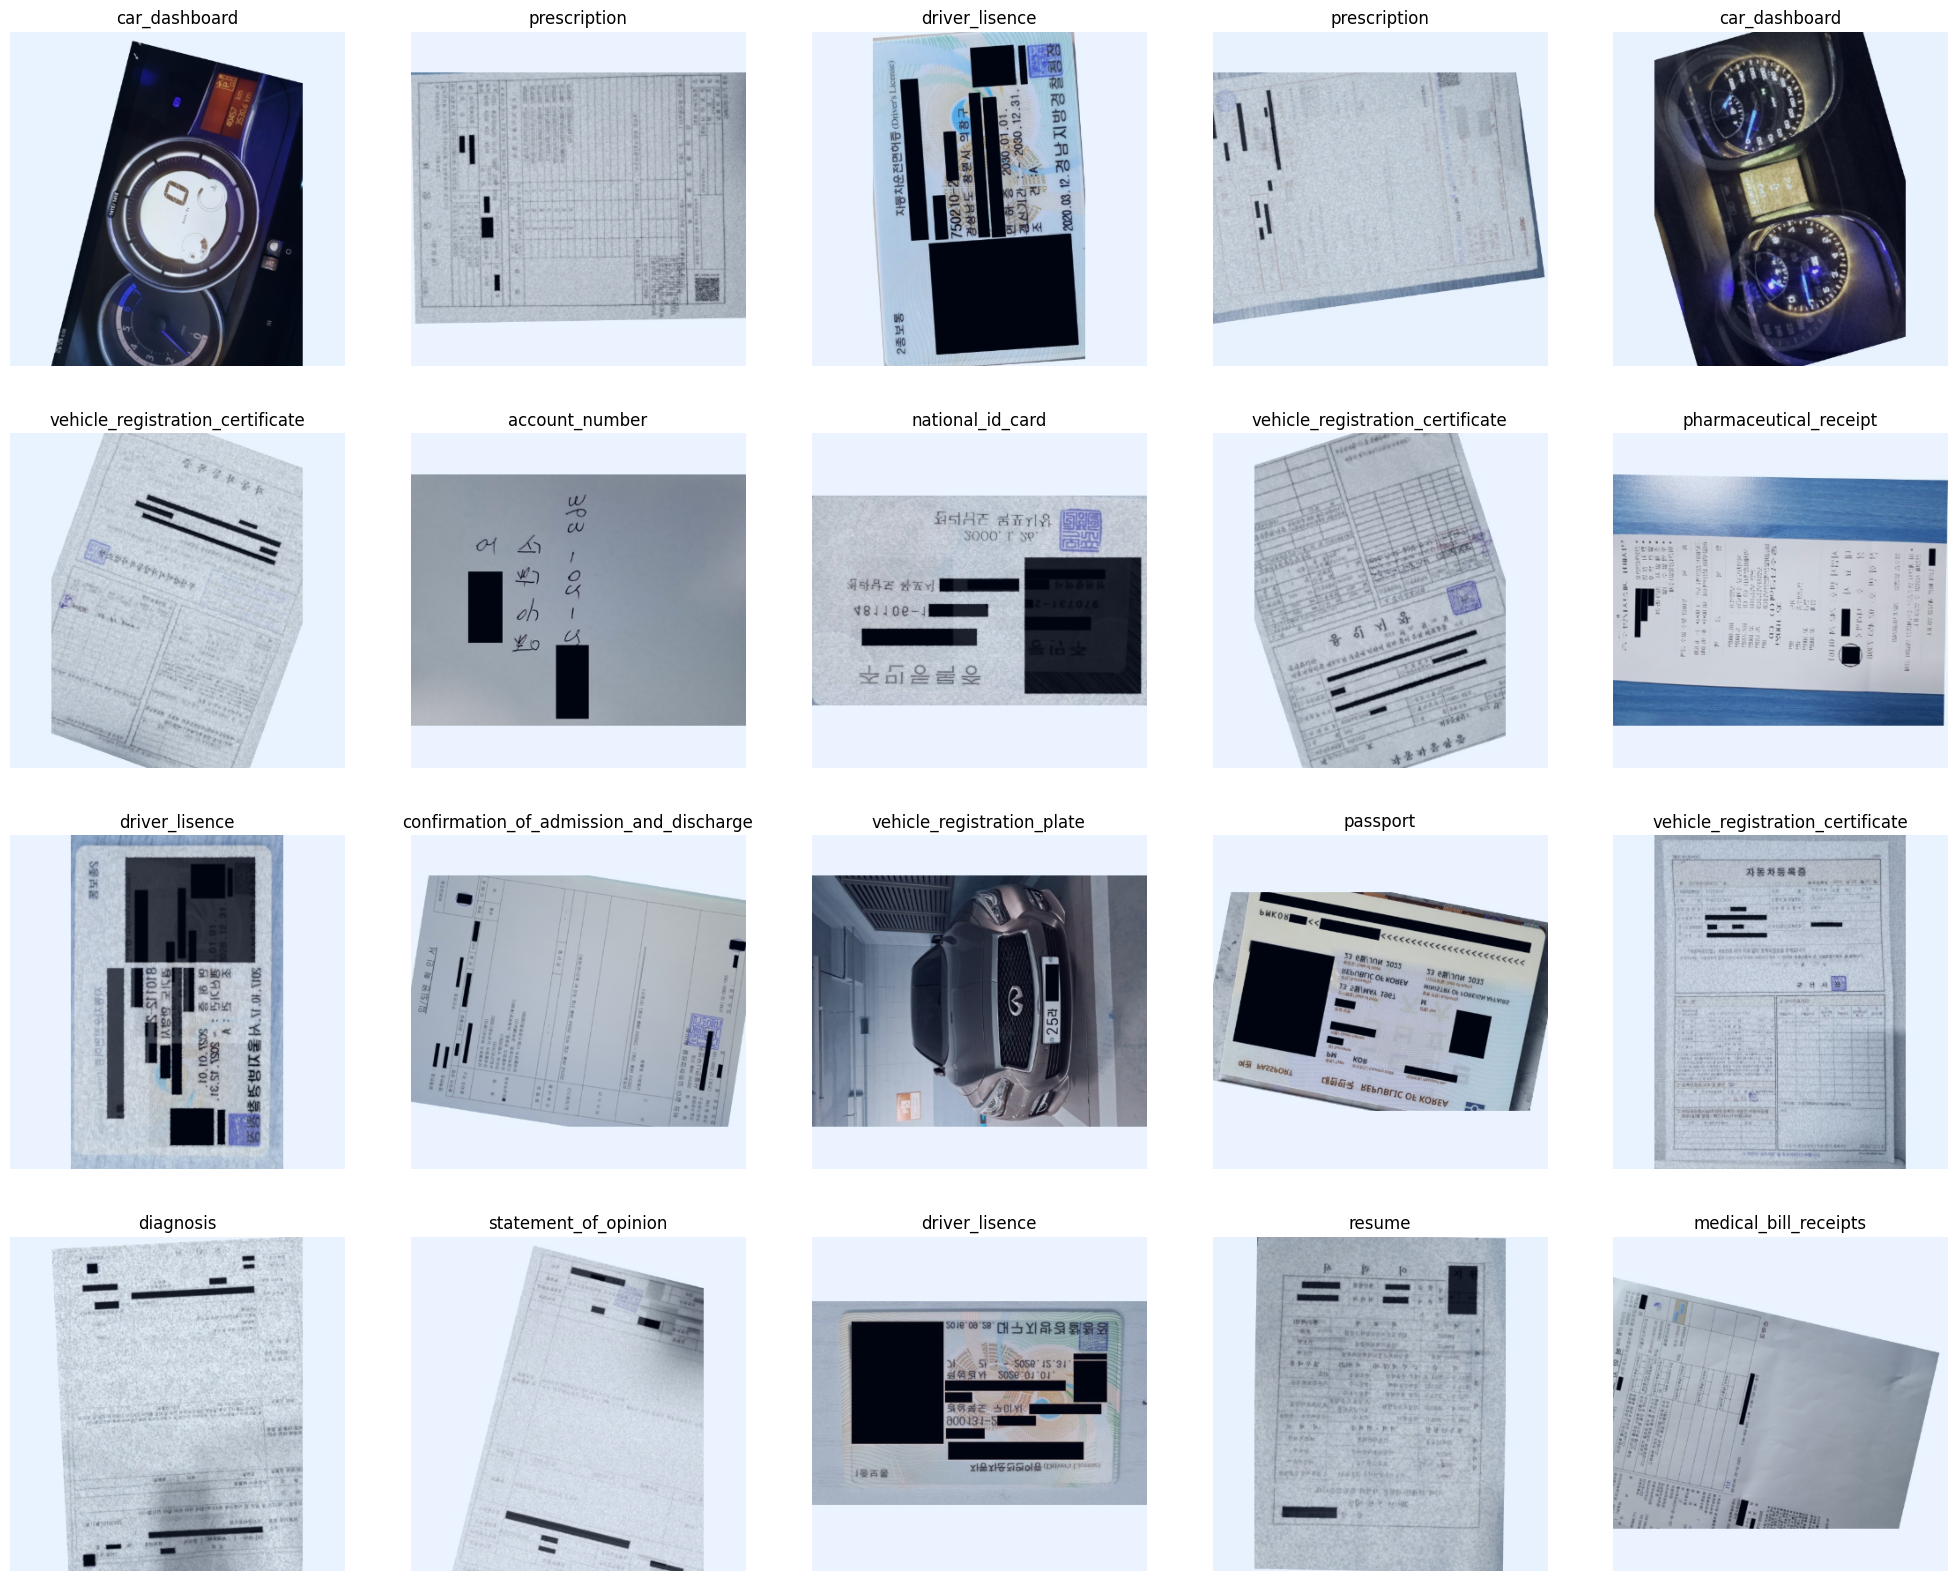

In [ ]:
# 시각화할 이미지 개수
img_count = 20

# 데이터셋의 총 길이를 가져옴
dataset_len = len(test_dataset)

# 무작위로 선택된 인덱스 리스트를 생성
selected_indices = random.sample(range(dataset_len), img_count)
print("index: ", selected_indices)

# 로컬에서 이미지 플로팅
num_rows = img_count // 5  # 행의 개수 계산
if img_count % 5 != 0:
    num_rows += 1    
fig, axes = plt.subplots(num_rows, 5, figsize=(25, 5 * num_rows))

# for i, idx in enumerate(selected_indices):
for i in range(img_count):
    test_dataset.df = pred_df
    image, label = test_dataset[i]
    row_idx = i // 5  
    col_idx = i % 5 
    
    # image = np.clip(image, 0, 1)  # 값이 0보다 작으면 0, 1보다 크면 1로 클리핑
    image = normalize_image(image)
    
    axes[row_idx, col_idx].imshow(image.permute(1, 2, 0))
    axes[row_idx, col_idx].set_title(label_to_class_name[label])
    axes[row_idx, col_idx].axis('off')

plt.show()

In [ ]:
curr_pred = pd.read_csv('ensemble_9593_9603_9562_3_final.csv') 
best_pred = pd.read_csv('9603.csv') 
merged_df = pd.merge(curr_pred, best_pred, on='ID', suffixes=('_pred1', '_pred2'))
different_targets = merged_df[merged_df['target_pred1'] != merged_df['target_pred2']]

selected_indices = different_targets.index.tolist()
print(len(selected_indices))

N_IMAGES = 90

# 로컬에서 이미지 플로팅
num_rows = N_IMAGES // 3  # 행의 개수 계산
if N_IMAGES % 3 != 0:
    num_rows += 1  
fig, axes = plt.subplots(num_rows, 3, figsize=(30, 10 * num_rows))

for i, idx in enumerate(selected_indices[:N_IMAGES]):
    test_dataset_v.df = curr_pred
    image, label = test_dataset_v[idx]
    row_idx = i // 3
    col_idx = i % 3
    
    axes[row_idx, col_idx].imshow(image.permute(1, 2, 0))
    axes[row_idx, col_idx].set_title(f'{label_to_class_name[label]} / {label_to_class_name[best_pred.values[idx][1]]}')
    axes[row_idx, col_idx].axis('off')

plt.show()

[185, 282, 383, 470, 605, 1036, 2348, 2353, 2445, 2876, 2990, 3009]


- 리더보드 기준 최상위 예측값 앙상블

In [ ]:
# 예측 파일 불러오기
pred1 = pd.read_csv("9603.csv")
pred2 = pd.read_csv("9593.csv")
pred3 = pd.read_csv("9562.csv")

# Combine predictions into a DataFrame
ensemble_df = pd.DataFrame({
    'ID': pred1['ID'],  # Assuming 'ID' column exists in all prediction files
    'pred1': pred1['target'],
    'pred2': pred2['target'],
    'pred3': pred3['target'],
    # 'pred4': pred4['target'],
    # 'pred5': pred5['target'],
})

# Perform majority voting to get the final prediction
ensemble_df['target'] = ensemble_df[['pred1', 'pred3', 'pred3']].mode(axis=1)[0].astype(int)

sample_submission_df = pd.read_csv(data_path + 'sample_submission.csv')
assert (sample_submission_df['ID'] == ensemble_df['ID']).all()

# Save the final predictions
ensemble_df[['ID', 'target']].to_csv('ensemble_9593_9603_9562_3.csv', index=False)